# All functions needed for curve fitting
* get runtimes data: ```gcloud compute operations --format=json list > m21.json```
* get instance types: ```gcloud compute instances list > instances-m21.txt```

## 3 ways to compute R^2

In [1]:
from scipy import stats
import numpy as np

x = np.random.random(10)
y = 1.6*x + np.random.random(10)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
y_hat = intercept + slope*x

ybar = np.mean(y)         # or sum(y)/len(y)
ssreg = np.sum((y_hat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
print(ssreg / sstot)

ssres = np.sum((y_hat-y)**2)
print(1-ssres / sstot)




slope: 1.206066    intercept: 0.599736
R-squared: 0.849352
0.8493523082849769
0.8493523082849763


In [2]:
#Filtering data based on machine type
import json
import pandas as pd
import numpy as np
import time
import datetime
import dateutil.parser 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
import math
from scipy.integrate import quad
from scipy.optimize import curve_fit
import glob
import inspect

#Instance types as a dic
def get_instance_types(path):
    try:
        frames = [ pd.read_csv(file,delim_whitespace=True, header=None) for file in sorted(glob.iglob(path)) ]
        instance_info = pd.concat(frames)
        instances = pd.Series(instance_info[2].values,index=instance_info[0].values).to_dict()
        del instances['NAME']
    except Exception as msg:
        print(msg)
        raise
    return instances

#Instance types as a dic
def get_instance_types_with_zone(path):
    try:
        frames = [ pd.read_csv(file,delim_whitespace=True, header=None) for file in sorted(glob.iglob(path)) ]
        instance_info = pd.concat(frames)
        #print(instance_info)
        target_type = 'n1-highcpu-16'
        instances = instance_info.loc[instance_info[2] == target_type]
        #print(instance_info.loc[instance_info[2] == target_type].shape)
        instances = pd.Series(instance_info[1].values,index=instance_info[0].values).to_dict()
        del instances['NAME']
    except Exception as msg:
        print(msg)
        raise
    return instances

# convert to mins
def ttl_in_minutes(start_time, end_time):
    s=dateutil.parser.parse(start_time)
    e=dateutil.parser.parse(end_time)
    diff = e-s
    return diff.total_seconds()

#from datetime import date
import calendar
def date_to_weekday(date):
    return calendar.day_name[dateutil.parser.parse(date).weekday()]

def idle_vs_not(date):
    date_start = '2019-03-07T00:00:00.000-00:00'
    date_start = dateutil.parser.parse(date_start)
    date = dateutil.parser.parse(date)
    idle_val = 'idle'
    if date > date_start:
        idle_val = 'non-idle'
    return idle_val

def date_to_hour(date):
    return dateutil.parser.parse(date).hour

#get all runtime information
def get_runtimes(path):
    out = dict()
    try:
        for file in sorted(glob.iglob(path)):
            with open(file) as json_file:  
                data = json.load(json_file)

            for entry in data:
                eid = entry['id']
                iname = entry['targetLink']
                if not iname in out:
                    if entry['operationType']=='insert':
                        out[iname] = (entry, np.nan)

            #Adding time data
            for entry in data:
                eid = entry['id']
                iname = entry['targetLink']      
                if entry['operationType']=='compute.instances.preempted':
                    if iname in out:
                        orig_entry = out[iname][0]
                        start_time = orig_entry['insertTime']
                        end_time = entry['insertTime']
                        ttl = ttl_in_minutes(start_time, end_time)
                        day_of_week = date_to_weekday(end_time)
                        hour_ = date_to_hour(end_time)
                        idle_para = idle_vs_not(end_time)
                        out[iname] = (orig_entry, ttl, day_of_week, hour_, idle_para)

        #removing the datapoint which did not have endtime
        #removing the datapoint which have longer time than 30 hours
        for i in list(out):
            if np.isnan(out[i][1]):
                out.pop(i)
            elif (out[i][1]/3600.0 > 30):
                print(out[i][0]['targetLink'])
                out.pop(i)
    except Exception as msg:
        print(msg)
        raise
    return out

#Creating lists for eah machine type
def get_runtimes_for_machine_type(runtimes, instances):
    all_data = dict() 
    try:
        assert(isinstance(runtimes, dict))
        assert(isinstance(instances, dict))
        for key, value in runtimes.items():   
            iname = key.split('/')[-1]
            if iname in instances:
                if instances[iname] in all_data:
                    all_data[instances[iname]].append(value[1]/3600.0)
                else:
                    all_data[instances[iname]] = [value[1]/3600.0]

        #Sorting            
        for key, value in all_data.items():
            all_data[key] = np.sort(all_data[key])
            
    except Exception as msg:
        print(msg)
        raise
    return all_data


#Creating lists for eah zone type
def get_runtimes_for_zone_type(runtimes, instances):
    all_data = dict() 
    try:
        assert(isinstance(runtimes, dict))
        assert(isinstance(instances, dict))
        for key, value in runtimes.items():   
            iname = key.split('/')[-1]
            if iname in instances:
                if instances[iname] in all_data:
                    all_data[instances[iname]].append(value[1]/3600.0)
                else:
                    all_data[instances[iname]] = [value[1]/3600.0]

        #Sorting            
        for key, value in all_data.items():
            all_data[key] = np.sort(all_data[key])
            
    except Exception as msg:
        print(msg)
        raise
    return all_data


#curve fitting sinh
def func_approx(t, R, t0, tau, C):
    return R*np.sinh((t-t0)/tau) + C

#curve fitting inverse sinh
def func_approx_inverse_by_interpolation(value, R, t0, tau, C):
    t=np.linspace(value-2, value+2, 10000, endpoint=True)
    values =func_approx(t, R, t0, tau, C)
    index_close_to_one = np.argmin(np.abs(values-1.0))
    return t[index_close_to_one]

#curve fitting inverse: This is junk due to periodic? behaviour sinh
def func_approx_inverse(f, R, t0, tau, C):
    return tau*np.arcsinh((f/R)-C) + t0

#derivative of the function sinh
def func_approx_dif(t, R, t0, tau, C):
    return R*np.cosh((t-t0)/tau)/tau

#Expected value function sinh
def func_approx_exp(t, R, t0, tau, C):
    return t*R*np.cosh((t-t0)/tau)/tau

#curve fitting exp
def func_approx_exponential(t, alpha):
    return (1.0 - np.exp(-alpha*t))

#curve fitting inverse sinh
def func_approx_exponential_inverse_by_interpolation(value, alpha):
    t=np.linspace(value-2, value+2, 10000, endpoint=True)
    values =func_approx_exponential(t, alpha)
    index_close_to_one = np.argmin(np.abs(values-1.0))
    return t[index_close_to_one]

#derivative of the function exp
def func_approx_exponential_dif(t, alpha):
    return alpha*np.exp(-alpha*t)

#Expected value function exp
def func_approx_exponential_exp(t, alpha):
    return t*alpha*np.exp(-alpha*t)


#################### New approx by Vikram#####################
def func_approx_4_param_expon(t, A, b, tau1, tau2):
    return A*(1.0-np.exp(-t/tau1) + np.exp((t-b)/tau2))

def hazard_rate_our_model(t, A, b, tau1, tau2):
    return ( (1/tau1)*np.exp(-t/tau1) + (1/tau2)*np.exp((t-b)/tau2) ) / (1/A - 1 + np.exp(-t/tau1) - np.exp((t-b)/tau2))

def func_approx_4_param_expon_inverse_by_interpolation(value, A, b, tau1, tau2):
    t=np.linspace(value-2, value+2, 10000, endpoint=True)
    values =func_approx_4_param_expon(t, A, b, tau1, tau2)
    index_close_to_one = np.argmin(np.abs(values-1.0))
    return t[index_close_to_one-1]

def func_approx_4_param_expon_dif(t, A, b, tau1, tau2):
    return A*((np.exp(-t/tau1)/tau1) + (np.exp((t-b)/tau2))/tau2)

#Expected value function exp
def func_approx_4_param_expon_exp(t, A, b, tau1, tau2):
    return t*A*((np.exp(-t/tau1)/tau1) + (np.exp((t-b)/tau2))/tau2)

# Compute the cross_entropy between two arrays
def cross_entropy(prediction, empirical, epsilon=1e-12):
    prediction = np.clip(prediction, epsilon, 1. - epsilon)
    return -np.sum(empirical*np.log(prediction+1e-9))/prediction.shape[0]

# Compute the MSE between two arrays
def mean_square_error(prediction, empirical):
    return (np.square(empirical - prediction)).mean(axis=0)

def r_squared_value(prediction, empirical):
    ybar = np.mean(empirical)         # or sum(y)/len(y)
    ssreg = np.sum((prediction-ybar)**2)   # or sum([ (yihat - ybar)**2 ])
    sstot = np.sum((empirical - ybar)**2)    # or sum([ (yi - ybar)**2 ])
    ssres = np.sum((prediction-empirical)**2)
    #return (ssreg / sstot)
    return (1-ssres / sstot)

#generate curve fitting for all the data for one of the machine grouping
def fit_data(all_data_conc, func_approx, func_approx_exp):
    temp_data = dict() 
    try:
        #Check whether data size is at least 4 points and if it has points in span of 10 hrs
        if (len(all_data_conc) > 3) and ((max(all_data_conc) - min(all_data_conc)) > 10 ): 
            temp_data['t'] = np.sort(all_data_conc)
            temp_data['cdf'] = np.linspace(0,1,len(all_data_conc), endpoint=True)
            #fit the curve: method= 'trf', 'dogbox' or 'lm'
            #‘trf’ : Trust Region Reflective algorithm, particularly suitable for large sparse problems with bounds. Generally robust method.
            #‘dogbox’ : dogleg algorithm with rectangular trust regions, typical use case is small problems with bounds. Not recommended for problems with rank-deficient Jacobian.
            #‘lm’ : Levenberg-Marquardt algorithm as implemented in MINPACK. Doesn’t handle bounds and sparse Jacobians. Usually the most efficient method for small unconstrained problems.
            #bounds=([0.1,10,0.1,0.1],[1,100,10,5.0])
            bounds=([0.1,10.0,0.1,0.1],[1,100.0,10,5]) #So far best for 4 parameter fit
            optimized_param, param_covariance = curve_fit(func_approx, temp_data['t'], temp_data['cdf'], maxfev=20000, method='trf', bounds=bounds)
            temp_data['optimized_params'] = optimized_param
            temp_data['param_covariance'] = param_covariance
            # Cross Entropy between fit and empirical data
            temp_data['cross_entropy'] = cross_entropy(func_approx(temp_data['t'], *temp_data['optimized_params']), temp_data['cdf'])
             # MSE between fit and empirical data
            temp_data['mean_square_error'] = mean_square_error(func_approx(temp_data['t'], *temp_data['optimized_params']), temp_data['cdf'])
            temp_data['r_squared_value'] = r_squared_value(func_approx(temp_data['t'], *temp_data['optimized_params']), temp_data['cdf'])
            
            #Expected value computation
            I = quad(func=func_approx_exp, a=temp_data['t'][0], b=temp_data['t'][-1],args=tuple(optimized_param))
            temp_data['expected_value'] = I
    except Exception as msg:
        print(msg)
        raise
    return temp_data


def emit_cdf(all_data_conc):
    outst = ""
    temp_data = dict() 
    temp_data['t'] = np.sort(all_data_conc)
    temp_data['cdf'] = np.linspace(0,1,len(all_data_conc), endpoint=True)
    z = zip(temp_data['t'], temp_data['cdf'])
    for tu in z:
        print("{} {}".format(tu[0], tu[1]))


#generate curve fitting data for all the curves considering machine grouping
def fit_all_types(all_data, func_approx, func_approx_exp):
    optimized_params = dict() 
    try:
        for key, value in all_data.items():
            #Check whether data size is at least 4 points and if it has points in span of 10 hrs
            if (len(value) > 3) and ((max(value) - min(value)) > 10 ):
                optimized_params[key] = fit_data(value, func_approx, func_approx_exp)
    except Exception as msg:
        print(msg)
        raise
    return optimized_params

# Plot the curve fitting data
def plot_CDF(key, value, func_approx, func_approx_dif, func_approx_inverse_by_interpolation):
    plt.figure(figsize=(5, 4))
    #plot data points
    plt.scatter(value['t'], value['cdf'], c='green', label='Empirical', s=5)
    # Save the data
    np.savetxt('runtime-data-by-group/'+key+'.txt', np.column_stack((value['t'],value['cdf'])), delimiter='\t')
    #find the value of t for when func_approx = 1.0
    edge_point_near_one = func_approx_inverse_by_interpolation(value['t'][-1],*value['optimized_params'] )
    
    np.savetxt('runtime-data-by-group/blended_exp_model/'+key+'_qqplot.txt', np.column_stack((value['t'], value['cdf'], func_approx(value['t'], *value['optimized_params']))), delimiter='\t')
    
    # Intepolate to get more data points for t
    #t=np.linspace(value['t'][0], value['t'][-1], 10000, endpoint=True)
    t=np.linspace(0, edge_point_near_one, 10000, endpoint=True)
    #Plot the fitted function : label='F(t)=R*np.sinh((t-t0)/tau) + C'
    plt.plot(t, func_approx(t, *value['optimized_params']), c= "red",  label='F(t)')
    
    np.savetxt('runtime-data-by-group/blended_exp_model/'+key+'.txt', np.column_stack((t,func_approx(t, *value['optimized_params']))), delimiter='\t')
    
    value_hazard=hazard_rate_our_model(t,*value['optimized_params'])
    plt.plot(t, value_hazard, c= "orange", label='lambda(t)')
    print(value_hazard[-10:])
    
    #differentiation of the funtion : label='dF(t)=R*np.cosh((t-t0)/tau)/tau'
    plt.plot(t, func_approx_dif(t, *value['optimized_params']), c= "blue", label='dF(t)')
    
    np.savetxt('runtime-data-by-group/blended_exp_model/'+key+'_diff.txt', np.column_stack((t,func_approx_dif(t, *value['optimized_params']))), delimiter='\t')
    
    
    x = plt.legend()
    plt.xlabel("Time(hrs)")
    plt.ylabel("CDF")
    #Plot text value['t']
    #creating function args list
    txt = ', fit: '
    function_args = inspect.getfullargspec(func_approx)[0]
    for i in range(len(function_args) -1):
        if float("{:.3f}".format( value['optimized_params'][i])) == 0.0:
            txt = txt +  function_args[i+1] +'=%.3E, '
        else:
            txt = txt +  function_args[i+1] +'=%.3f, ' 
        
    txt = txt % tuple(value['optimized_params'])
    text = key + txt + ', E(t)=%.3f ' % (value['expected_value'][0]) + ', CrossEntropy=%.3f ' % (value['cross_entropy'])
    text = text + ', MSE=%.3f ' % (value['mean_square_error'])
    text = text + ', R^2=%.3f ' % (value['r_squared_value'])
    plt.ylim(0,2)
    plt.title(text)

# Plot the curve fitting data
def plot_two_CDF(key, value,value2, func_approx, func_approx_dif, func_approx_inverse_by_interpolation,  
                 func_approx2, func_approx_dif2, func_approx_inverse_by_interpolation2):
    
    plt.figure(figsize=(5, 4))
    #plot data points
    plt.scatter(value['t'], value['cdf'], c='green', label='Empirical', s=5)
    
    #find the value of t for when func_approx = 1.0
    edge_point_near_one = func_approx_inverse_by_interpolation(value['t'][-1],*value['optimized_params'] )
    
    # Intepolate to get more data points for t
    #t=np.linspace(value['t'][0], value['t'][-1], 10000, endpoint=True)
    t=np.linspace(0, edge_point_near_one, 10000, endpoint=True)
    #Plot the fitted function : label='F(t)=R*np.sinh((t-t0)/tau) + C'
    plt.plot(t, func_approx(t, *value['optimized_params']), c= "red",  label='F(t)')
    #differentiation of the funtion : label='dF(t)=R*np.cosh((t-t0)/tau)/tau'
    plt.plot(t, func_approx_dif(t, *value['optimized_params']), c= "blue", label='dF(t)')
    
    #2nd plot
    edge_point_near_one2 = func_approx_inverse_by_interpolation2(value2['t'][-1],*value2['optimized_params'] )
    t2=np.linspace(0, edge_point_near_one2, 10000, endpoint=True)
    plt.plot(t2, func_approx2(t2, *value2['optimized_params']), c= "black",  label='F2(t)')
    #plt.plot(t2, func_approx_dif2(t2, *value2['optimized_params']), c= "purple", label='dF2(t)')
    
    x = plt.legend()
    plt.xlabel("Time(hrs)")
    plt.ylabel("CDF")
    #Plot text value['t']
    #creating function args list
    txt = ', fit: '
    function_args = inspect.getfullargspec(func_approx)[0]
    for i in range(len(function_args) -1):
        if float("{:.3f}".format( value['optimized_params'][i])) == 0.0:
            txt = txt +  function_args[i+1] +'=%.3E, '
        else:
            txt = txt +  function_args[i+1] +'=%.3f, ' 
        
    txt = txt % tuple(value['optimized_params'])
    text = key + txt + ', E(t)=%.3f ' % (value['expected_value'][0]) + ', CrossEntropy=%.3f ' % (value['cross_entropy'])
    text = text + ', MSE=%.3f ' % (value['mean_square_error'])
    plt.title(text)    
    
# Plot the curve fitting data
def plot_all_types(optimized_params, func_approx, func_approx_dif, func_approx_inverse_by_interpolation):
    try:
        for key, value in optimized_params.items():
            #Plot text
            plot_CDF(key, value, func_approx, func_approx_dif, func_approx_inverse_by_interpolation)
            
    except Exception as msg:
        print(msg)
        raise

## Group by zone type

In [3]:
#Get instance data
instances = get_instance_types_with_zone('instance-data/instances*.txt')

#Get runtime data
runtime_data = get_runtimes('runtime-data/*.json')

#Get runtime data per machine type
all_data = get_runtimes_for_zone_type(runtime_data, instances)

#print(all_data)
#instances

https://www.googleapis.com/compute/v1/projects/first-220321/zones/us-east1-b/instances/abacus2
https://www.googleapis.com/compute/v1/projects/first-220321/zones/us-east1-b/instances/abacus3


[  43.44117686   48.82789551   55.71654058   64.83697446   77.48337178
   96.19029123  126.68698151  185.24668513  343.61341403 2327.911769  ]
[  42.99570473   48.30621526   55.08518591   64.03935815   76.41565426
   94.63918088  124.13514328  180.04537636  326.61894147 1729.34820207]
[  41.53328014   47.0306553    54.06448251   63.38192173   76.30829769
   95.44047915  126.65298681  186.65303656  349.30651839 2434.90915728]
[  43.40543462   48.86346549   55.85028993   65.11269112   77.97843511
   97.05768416  128.28404348  188.67411826  354.87261007 2869.91527499]


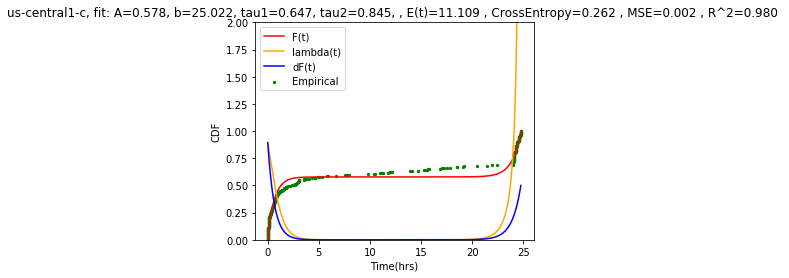

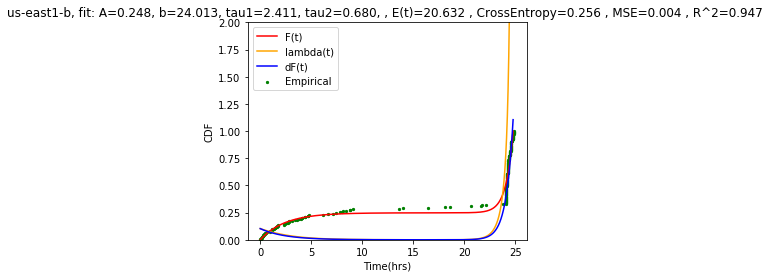

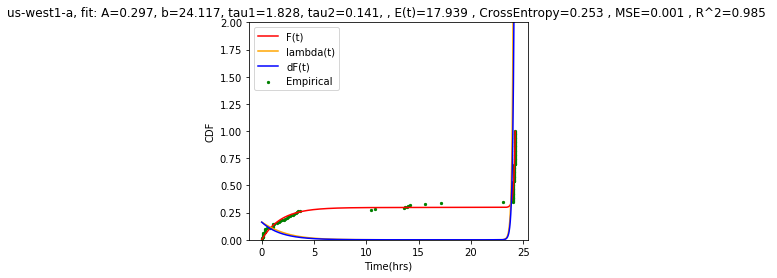

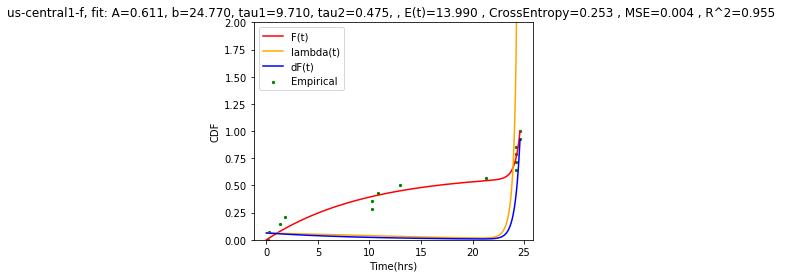

In [4]:
#generate curve fitting data for all the curves
optimized_parameters_group_by_machine = fit_all_types(all_data, func_approx_4_param_expon, func_approx_4_param_expon_exp)

# Plot the curve fitting data
plot_all_types(optimized_parameters_group_by_machine, func_approx_4_param_expon, func_approx_4_param_expon_dif, func_approx_4_param_expon_inverse_by_interpolation)

### Group by machine type

In [5]:
#Get instance data
instances = get_instance_types('instance-data/instances*.txt')

#Get runtime data
runtime_data = get_runtimes('runtime-data/*.json')

#Get runtime data per machine type
all_data = get_runtimes_for_machine_type(runtime_data, instances)

#print(all_data)

https://www.googleapis.com/compute/v1/projects/first-220321/zones/us-east1-b/instances/abacus2
https://www.googleapis.com/compute/v1/projects/first-220321/zones/us-east1-b/instances/abacus3


[  43.22176207   48.54926266   55.35026077   64.33412933   76.75262197
   95.04075015  124.64757333  180.78946083  328.10464054 1747.85064093]
[  43.27517602   48.65011774   55.52371513   64.62423653   77.24302592
   95.90908683  126.33907176  184.77025781  342.78626774 2322.28410854]
[  43.40404945   48.79686934   55.69127485   64.81578715   77.46112022
   96.15210945  126.58606589  184.89767893  341.75715882 2208.95058573]
[  43.24169099   48.61834366   55.48863533   64.57526994   77.15685491
   95.7296578   125.91007453  183.52514934  337.14945264 2025.40151444]
[  43.19108855   48.4466291    55.15454025   64.01339048   76.25529164
   94.27549315  123.42889946  178.6447087   323.11978226 1685.76164579]
[  42.43730885   47.64159729   54.29686773   63.10822395   75.32593738
   93.39857982  122.86101299  179.43426145  332.42693743 2249.20161903]
[  43.85422945   49.3042237    56.28280685   65.53794448   78.4006992
   97.49099063  128.77582414  189.42266432  357.3157837  3088.73979782]


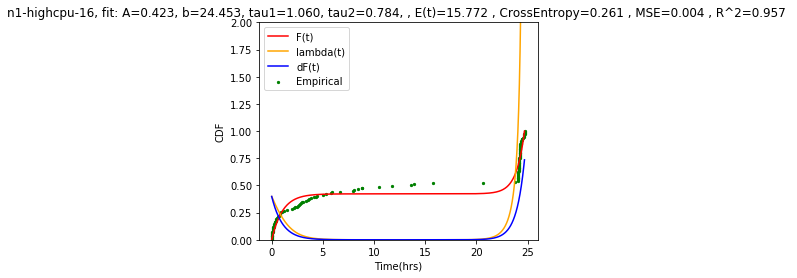

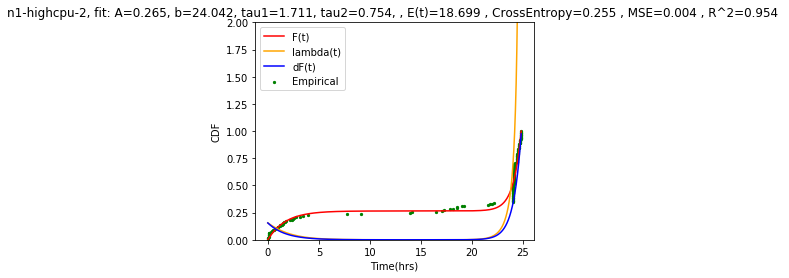

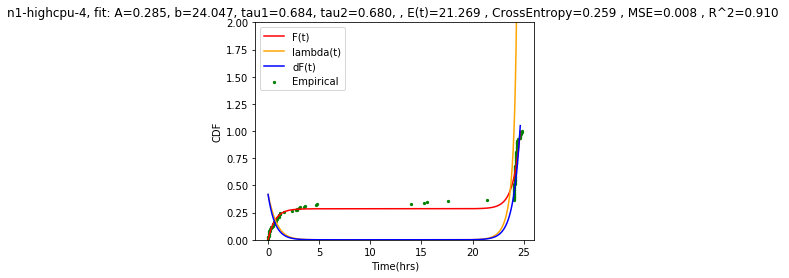

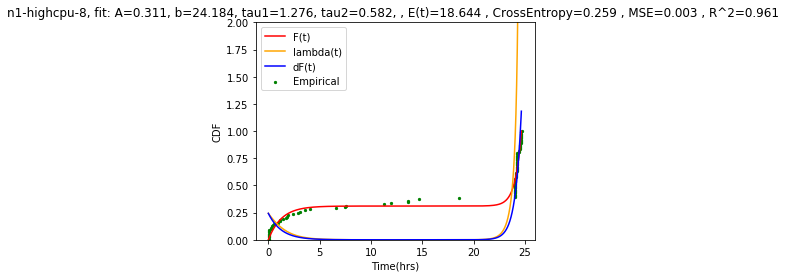

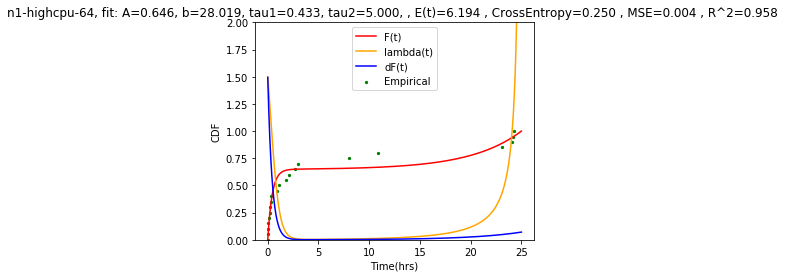

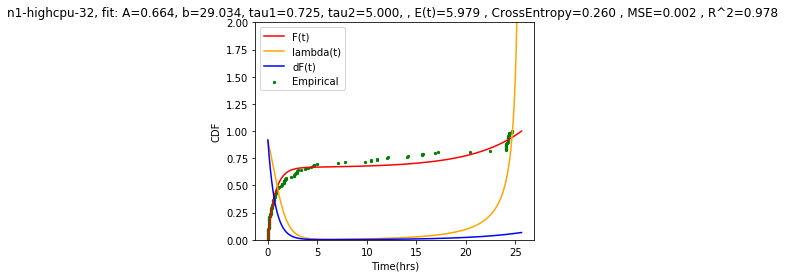

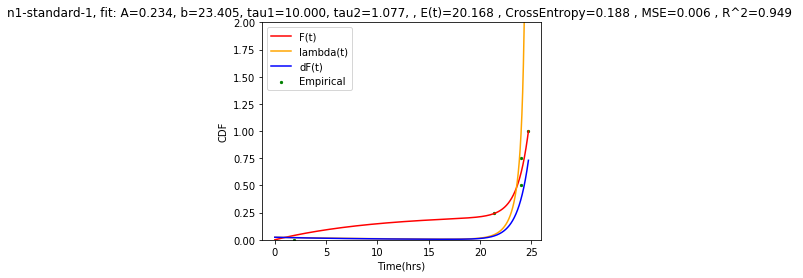

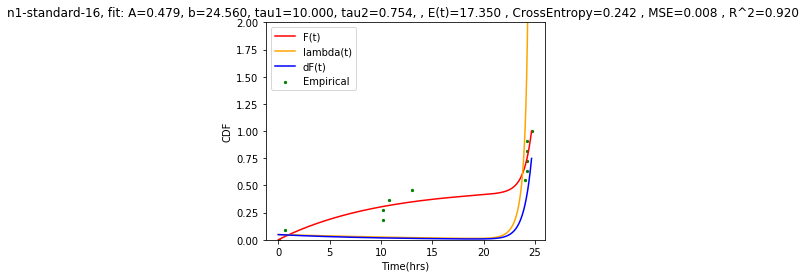

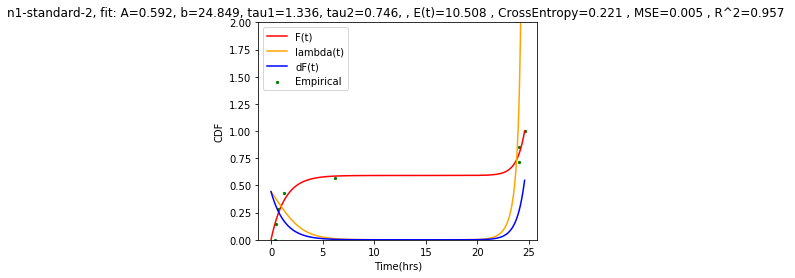

In [6]:

#generate curve fitting data for all the curves
optimized_parameters_group_by_machine = fit_all_types(all_data, func_approx_4_param_expon, func_approx_4_param_expon_exp)

# Plot the curve fitting data
plot_all_types(optimized_parameters_group_by_machine, func_approx_4_param_expon, func_approx_4_param_expon_dif, func_approx_4_param_expon_inverse_by_interpolation)


### Different time of day; day-of-week

In [7]:
#Creating lists for eah machine type
def get_runtimes_for_days_of_week(runtimes):
    all_data = dict() 
    try:
        assert(isinstance(runtimes, dict))
        for key, value in runtimes.items():   
            day = value[2]
            if day in all_data:
                all_data[day].append(value[1]/3600.0)
            else:
                all_data[day] = [value[1]/3600.0]

        #Sorting            
        for key, value in all_data.items():
            all_data[key] = np.sort(all_data[key])
            
    except Exception as msg:
        print(msg)
        raise
    return all_data


#Get runtime data per machine type
all_data_days_of_week = get_runtimes_for_days_of_week(runtime_data)

#print(all_data_days_of_week)

[ 116.67821487  130.34851121  147.64373073  170.22607369  200.95736644
  245.2195392   314.47168884  438.20173905  722.37072473 2054.37137949]
[  43.76788067   49.26870923   56.32307444   65.69724643   78.76059613
   98.22429072  130.31797775  193.2387245   372.44298392 4911.73024777]
[  43.0467023    48.36151509   55.1466309    64.11004935   76.50125077
   94.75122904  124.30140288  180.35314257  327.53912126 1754.04650064]
[  43.965094     49.46077483   56.50244938   65.84920147   78.85431291
   98.18813701  129.95559561  191.835074    365.2124394  3691.70469517]
[  41.57894538   46.6730681    53.18582489   61.80567908   73.75254728
   91.41324428  120.17522461  175.30329086  323.73109343 2105.55567111]
[  43.1835354    48.53582927   55.37209144   64.40873252   76.91174955
   95.34879386  125.25847242  182.18509371  332.88218939 1890.7820551 ]
[  43.726825     49.18728996   56.17422253   65.43162545   78.28079729
   97.31501778  128.41530916  188.37829585  352.16627145 2628.1479716 ]

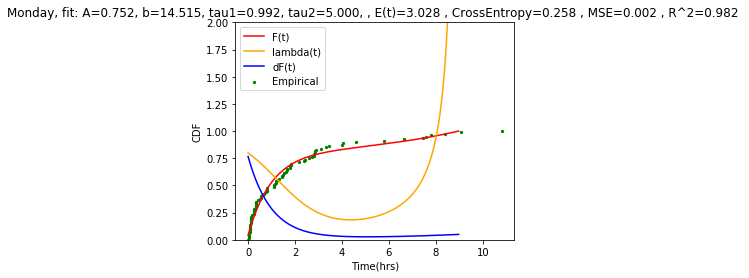

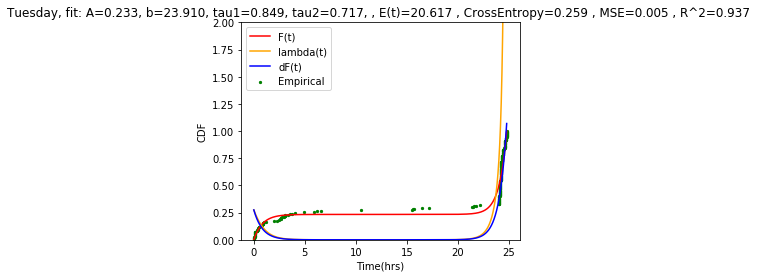

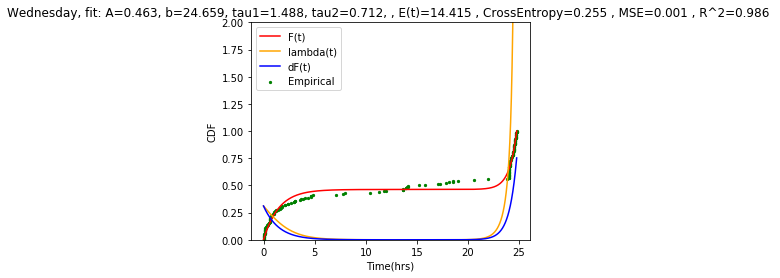

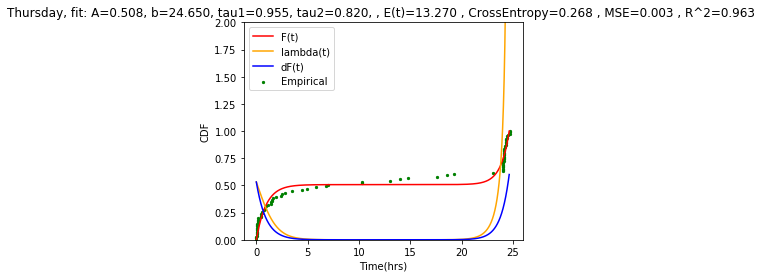

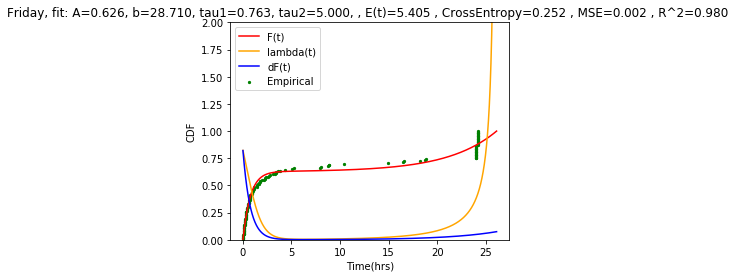

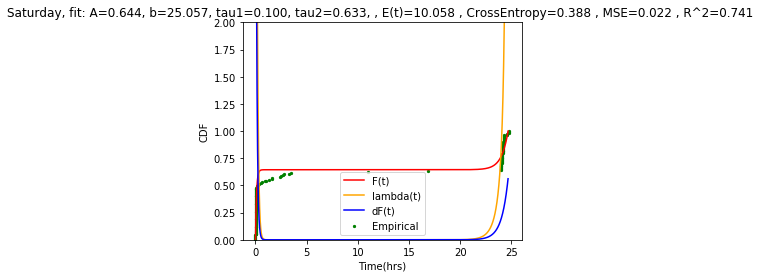

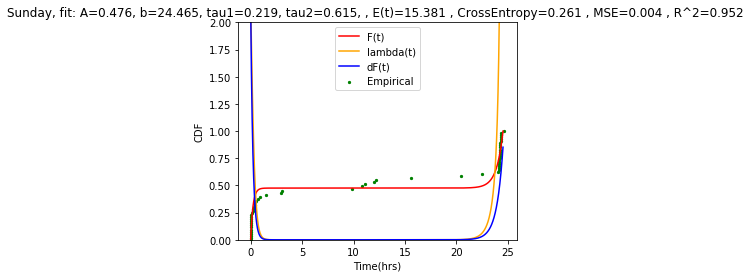

In [8]:
#generate curve fitting data for all the curves
optimized_parameters_days_of_week = fit_all_types(all_data_days_of_week, func_approx_4_param_expon, func_approx_4_param_expon_exp)

# Plot the curve fitting data
plot_all_types(optimized_parameters_days_of_week, func_approx_4_param_expon, func_approx_4_param_expon_dif, func_approx_4_param_expon_inverse_by_interpolation)


### Different hours of day; within 24hrs

In [9]:
#Creating lists for eah machine type
def get_runtimes_for_24_hrs(runtimes):
    all_data = dict() 
    try:
        assert(isinstance(runtimes, dict))
        for key, value in runtimes.items():   
            hours_val = value[3]
            if hours_val<4:
                hours_val = '0-4'
            elif hours_val<8: 
                hours_val = '4-8'
            elif hours_val<12: 
                hours_val = '8-12'
            elif hours_val<16: 
                hours_val = '12-16'
            elif hours_val<20: 
                hours_val = '16-20'
            else:
                hours_val = '20-24'
                
            if hours_val in all_data:
                all_data[hours_val].append(value[1]/3600.0)
            else:
                all_data[hours_val] = [value[1]/3600.0]

        #Sorting            
        for key, value in all_data.items():
            all_data[key] = np.sort(all_data[key])
            
    except Exception as msg:
        print(msg)
        raise
    return all_data


#Get runtime data per machine type
all_data_24_hrs = get_runtimes_for_24_hrs(runtime_data)

#print(all_data_24_hrs)

[  43.08795683   48.43818387   55.27279858   64.3089591    76.81448216
   95.2619162   125.20538762  182.25420833  333.64186461 1930.55622466]
[  43.72662992   49.18976894   56.18763599   65.47257379   78.3847163
   97.56536281  129.04231527  190.21768174  360.65528224 3376.56406544]
[  43.2487343    48.56139498   55.3429894    64.30045686   76.68104137
   94.9104014   124.41473062  180.33746856  326.92392633 1728.34835694]
[  43.32172135   48.64991119   55.45022101   64.43049407   76.83899679
   95.10183377  124.64106074  180.56453077  326.74744063 1695.3109995 ]
[  65.76018382   73.76268053   83.97783849   97.47056053  116.11967491
  143.57924547  188.02371007  272.26774052  493.11450324 2606.25324579]
[  43.62029426   49.0653983    56.03368174   65.2681239    78.08874293
   97.08777476  128.14888057  188.10059202  352.29071137 2701.46581893]


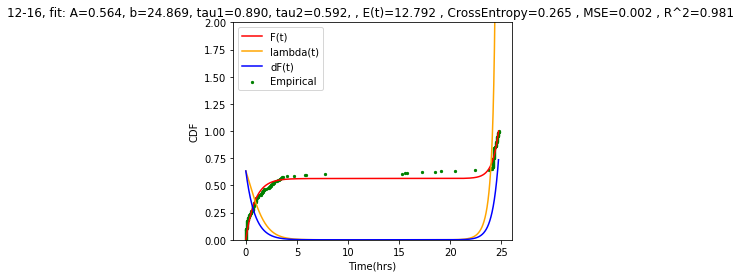

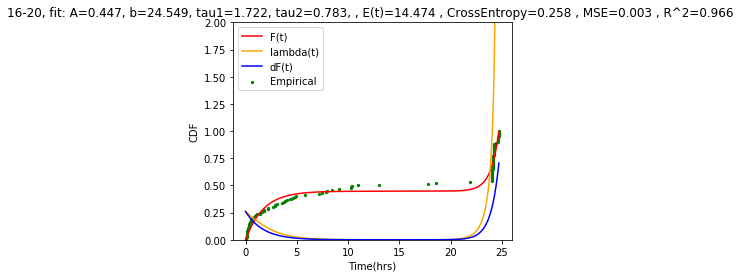

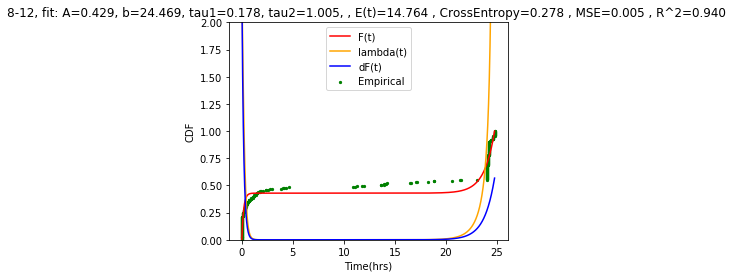

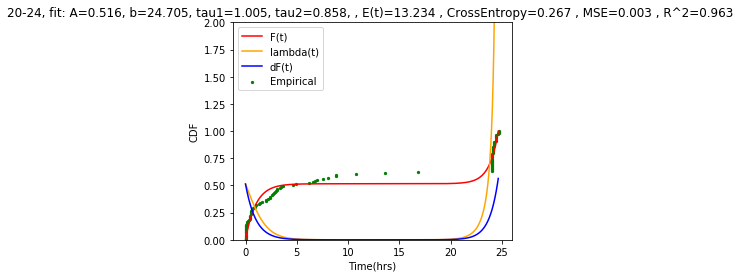

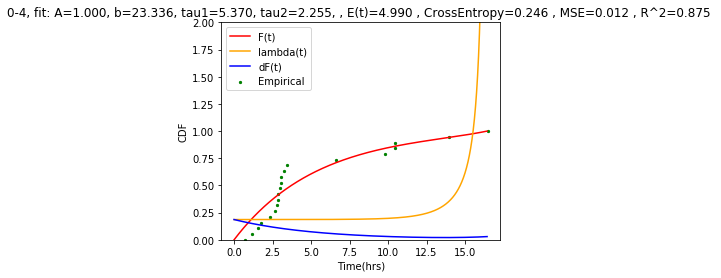

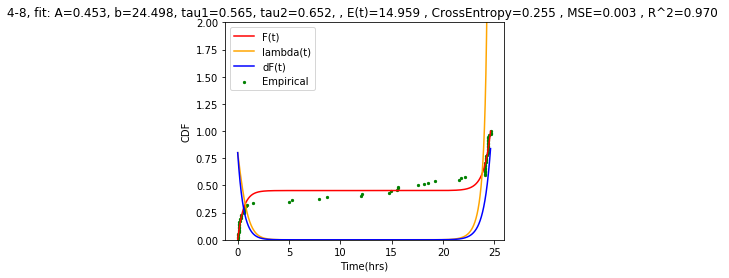

In [10]:
#generate curve fitting data for all the curves
optimized_parameters_24_hrs = fit_all_types(all_data_24_hrs, func_approx_4_param_expon, func_approx_4_param_expon_exp)

# Plot the curve fitting data
plot_all_types(optimized_parameters_24_hrs, func_approx_4_param_expon, func_approx_4_param_expon_dif, func_approx_4_param_expon_inverse_by_interpolation)

In [11]:
def get_day_night_runtimes(runtimes):
    all_data = dict() 
    try:
        assert(isinstance(runtimes, dict))
        for key, value in runtimes.items():   
            hours_val = value[3]
            if (hours_val>=0 and hours_val<8) or (hours_val>=20) :
                hours_val = 'Night'
            else:
                hours_val = 'Day'
                
            if hours_val in all_data:
                all_data[hours_val].append(value[1]/3600.0)
            else:
                all_data[hours_val] = [value[1]/3600.0]

        #Sorting            
        for key, value in all_data.items():
            all_data[key] = np.sort(all_data[key])
            
    except Exception as msg:
        print(msg)
        raise
    return all_data


#Get runtime data per machine type
all_day_night = get_day_night_runtimes(runtime_data)


[  43.45551825   48.84231557   55.73034755   64.84873693   77.48997483
   96.18430968  126.64781749  185.09981646  342.88609545 2284.77519227]
[  43.4018416    48.76131013   55.60645354   64.65437662   77.1721845
   95.62936773  125.56758692  182.53464095  333.25167533 1884.00823259]


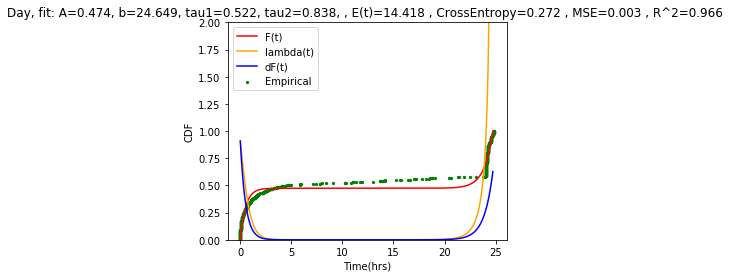

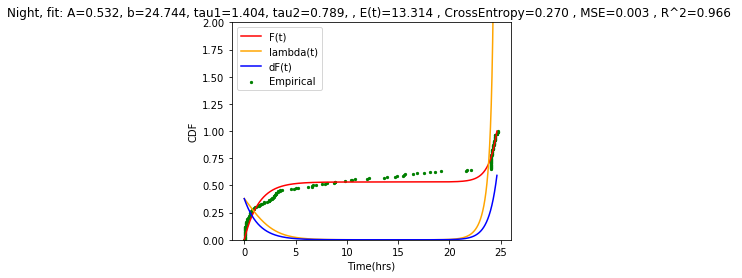

In [12]:
#generate curve fitting data for all the curves
optimized_parameters_24_hrs = fit_all_types(all_day_night, func_approx_4_param_expon, func_approx_4_param_expon_exp)

# Plot the curve fitting data
plot_all_types(optimized_parameters_24_hrs, func_approx_4_param_expon, func_approx_4_param_expon_dif, func_approx_4_param_expon_inverse_by_interpolation)

### idle vs non-idle

In [13]:
#Creating lists for eah machine type
def get_runtimes_for_idle_vs_non(runtimes):
    all_data = dict() 
    try:
        assert(isinstance(runtimes, dict))
        for key, value in runtimes.items():   
            idle_v = value[4]
            if idle_v in all_data:
                all_data[idle_v].append(value[1]/3600.0)
            else:
                all_data[idle_v] = [value[1]/3600.0]

        #Sorting            
        for key, value in all_data.items():
            all_data[key] = np.sort(all_data[key])
            
    except Exception as msg:
        print(msg)
        raise
    return all_data


#Get runtime data per machine type
all_data_idle_vs_non = get_runtimes_for_idle_vs_non(runtime_data)

#print(all_data_idle_vs_non)

[  43.67681998   49.11574595   56.07864559   65.31034983   78.13552773
   97.15927865  128.30720392  188.5901217   354.80034922 2926.38119144]
[  43.23266575   48.56295236   55.36931338   64.36337847   76.80181066
   95.13167492  124.83736794  181.27329615  330.02702974 1814.98907762]


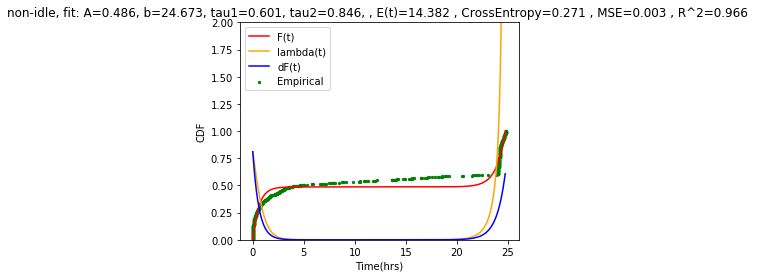

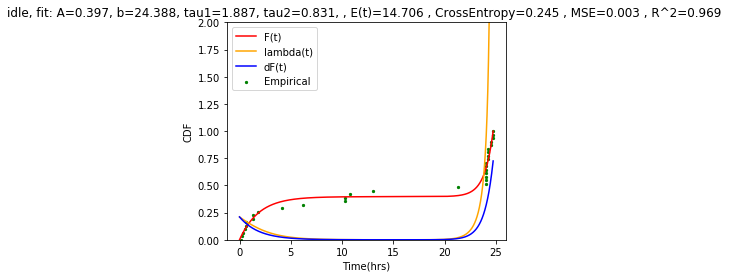

In [14]:
#generate curve fitting data for all the curves
optimized_parameters_idle = fit_all_types(all_data_idle_vs_non, func_approx_4_param_expon, func_approx_4_param_expon_exp)

# Plot the curve fitting data
plot_all_types(optimized_parameters_idle, func_approx_4_param_expon, func_approx_4_param_expon_dif, func_approx_4_param_expon_inverse_by_interpolation)

In [15]:
runtime_data['https://www.googleapis.com/compute/v1/projects/first-220321/zones/europe-north1-a/instances/aardvark27'][0]

#'2018-06-29 08:15:27.243860'
#runtime_data['https://www.googleapis.com/compute/v1/projects/first-220321/zones/europe-north1-a/instances/aardvark27'][2]

date1 = '2019-02-01T11:42:52.506-08:00'
date2 = '2019-03-01T00:00:00.000-00:00'

date1 = dateutil.parser.parse(date1)
date2 = dateutil.parser.parse(date2)
date1 > date2

False

# Curve fitting with exp for for all the results without considering machine type

[  43.74678346   49.21993444   56.23255003   65.54039166   78.49070902
   97.74165188  129.36920694  190.96282768  363.44519328 3646.11322096]


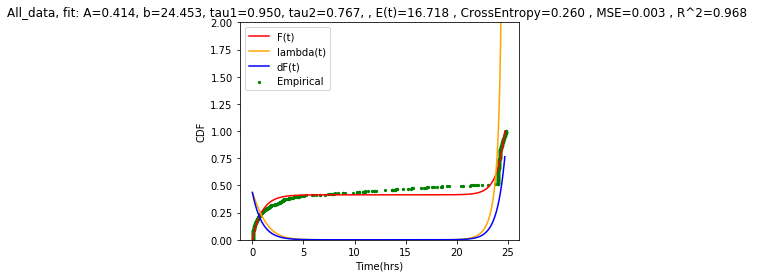

In [16]:
all_data_conc2 = []
for key, value in all_data.items():
    for i in range(value.shape[0]):
        all_data_conc2.append(value[i]) 

#Fit the data for all the data points
opt_params_all2 = fit_data(all_data_conc2, func_approx_4_param_expon, func_approx_4_param_expon_exp)

plot_CDF("All_data",opt_params_all2, func_approx_4_param_expon, func_approx_4_param_expon_dif, func_approx_4_param_expon_inverse_by_interpolation)